<a href="https://colab.research.google.com/github/tontantip/DADS7202-Deep_learning/blob/main/study_NeuralNetWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup Library

In [26]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

## Donwload dataset

In [27]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

## Setup Batch size

In [28]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)


In [29]:
## ตรวจสอบตัวช่วยในการประมวลผลหรือไม่ถ้าไม่มีให้ใช้ cpu
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        ## รีด data จากภาพที่มีขนาด 28*28 pixel ให้เป็น data
        self.flatten = nn.Flatten()
        ## สร้าง layerมาต่อกันตามลำดับ
        self.linear_relu_stack = nn.Sequential(
            ## input layer มี 784 node และออกไป 521 node เป็น hiden layer 1
            nn.Linear(28*28, 512),
            ## hiden layer 1 ใช้ Activation function เป็น ReLU
            nn.ReLU(),
            ## hiden layer 2 มี 512 node และออกไป 512 node เป็น hiden layer 3
            nn.Linear(512, 512),
            ## hiden layer 2 ใช้ Activation function ReLU
            nn.ReLU(),
            ## จาก hiden layer 3 512 node เป็น output layer 10 node (ตามจำนวน class ของ data)
            nn.Linear(512, 10)
        )
    ## กำหนด pipeline ของ Deep learning เริ่มจากการ flatten รีด data จาก 28 * 28 เป็น 784
    ## จากนั้นเรา hidden layer จะได้ output layer ออกมาว่าเป็น class (เป็นตัวเลข 10 ตัว)
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        ## ใช้ return class ออกมา
        return logits
## สร้าง model แล้วเก็บไว้ในตัวแปร model โดยที่ .to(device) เป็นการส่ง model ให้ GPU เพื่อเตรียมในการ train
model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [30]:
## กำหนด Loss function เป็น Cross Entropy
loss_fn = nn.CrossEntropyLoss()
## กำหนด การ Optimize ใช้ Stochastic grasient Descent และกำหนด learning rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [31]:
## เตรียม function สำหรับการ train model โดยมี input เป็น data_tain, model, loss function, optimize
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    ## ต้องใส่เพื่อบอกว่าตอนนี้กำลังอยู่ใน mode training นะ
    model.train()
    print(size)
    ## ย้าย data เข้าในตัวแปร X เป็น data รูปภาพ และ y เป็น label ของภาพ
    for batch, (X, y) in enumerate(dataloader):
        ## ย้ายทั้ง data รูปภาพและ label ไปไว้ที่ GPU เพื่อประมวลผล
        X, y = X.to(device), y.to(device)

        # model ทำนาย class จาก Data ของภาพตามขั้นตอน nuerual network ที่กำหนดไว้
        pred = model(X)
        # หาค่า loss function ที่จากการ predict
        loss = loss_fn(pred, y)

        # ขั้นตอนการทำ Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        ## ให้ปริ้นทุกๆครั้งที่ทำเสร็จ 100 ครั้ง เพื่อดูว่า loss ยังลดลงอยู่หรือไม่
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [35]:
## สร้าง function เพื่อ test data โดย data ที่ input ได้แก่ data สำหรับ eval (test_set), model, loss function
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    ## ต้องบอกเพื่อให้ model รู้ว่าอยู่ใน model test (eval)
    model.eval()
    ## ประกาศตัวแปรเริ่มต้นว่า test_loss (ค่า loss) เป็น 0, ค่า Correct เป็น 0
    test_loss, correct = 0, 0
    ## คำสั่ง torch.no_grad เป็นการบอกว่าในการ test ไม่ต้องการปรับ weight นะ
    with torch.no_grad():
        ## แยก data รูปภาพ กับ label ของภาพใส่ไว้ในตัวแปร X, y
        for X, y in dataloader:
            ## ส่งทั้ง data รูปภาพและ label ของภาพไปไว้ที่ GPU
            X, y = X.to(device), y.to(device)
            ## ทำการ predict data test (eval)
            pred = model(X)
            ## รวมทั้งค่า loss แลเค่า correct ว่ารวมกันได้เท่าไรใช้การ predict แต่ละค่า
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    ## นำค่า loss function และ ค่า Correct มาหาค่าเฉลี่ย
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

In [36]:
epochs = 5
best_acc = 0  # 1. ตั้งตัวแปรเก็บคะแนนสูงสุดไว้ที่ 0

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)

    # 2. รับค่า accuracy มาจากฟังก์ชัน test
    current_acc = test(test_dataloader, model, loss_fn)
    # 3. เช็คว่ารอบนี้เก่งกว่ารอบที่ผ่านๆ มาไหม
    if current_acc > best_acc:
        best_acc = current_acc
        # บันทึกเฉพาะเมื่อมันเก่งขึ้นเท่านั้น
        torch.save(model.state_dict(), "best_model.pth")
        print(f"✨ New Best Model saved with accuracy: {(100*best_acc):>0.1f}%")

print("Done!")

Epoch 1
-------------------------------
60000
loss: 1.920610  [   64/60000]
loss: 1.887214  [ 6464/60000]
loss: 1.775085  [12864/60000]
loss: 1.813837  [19264/60000]
loss: 1.697235  [25664/60000]
loss: 1.657324  [32064/60000]
loss: 1.674099  [38464/60000]
loss: 1.586667  [44864/60000]
loss: 1.609250  [51264/60000]
loss: 1.495323  [57664/60000]
Test Error: 
 Accuracy: 62.1%, Avg loss: 1.515243 

✨ New Best Model saved with accuracy: 62.1%
Epoch 2
-------------------------------
60000
loss: 1.586117  [   64/60000]
loss: 1.546119  [ 6464/60000]
loss: 1.400103  [12864/60000]
loss: 1.463070  [19264/60000]
loss: 1.340470  [25664/60000]
loss: 1.350475  [32064/60000]
loss: 1.349963  [38464/60000]
loss: 1.293901  [44864/60000]
loss: 1.322078  [51264/60000]
loss: 1.213246  [57664/60000]
Test Error: 
 Accuracy: 63.5%, Avg loss: 1.243105 

✨ New Best Model saved with accuracy: 63.5%
Epoch 3
-------------------------------
60000
loss: 1.326939  [   64/60000]
loss: 1.301729  [ 6464/60000]
loss: 1.13

In [ ]:
'''torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")'''

In [37]:
## ร่าง model เปล่าขึ้นมาโดยใช้ NeuralNetwork().to(device)
model = NeuralNetwork().to(device)
## load model ที่ save ไว้มาใส่ใน model
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

In [47]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[4][0], test_data[4][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Shirt", Actual: "Shirt"


In [43]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

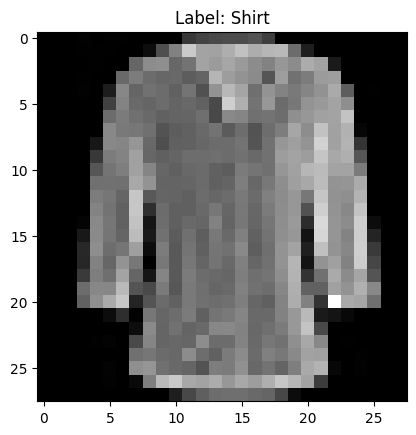

In [46]:
import matplotlib.pyplot as plt

img, label = test_data[4] # ดึงรูปที่ 3
plt.imshow(img.squeeze(), cmap="gray") # squeeze() เพื่อเอาตัวเลขมิติ 1 ออก
plt.title(f"Label: {classes[label]}")
plt.show()